In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pickup_utils import session_before_after_features
from pickup_utils import session_feature_engineering
from pickup_utils import session_join_zone_whl_orders_users
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Checkout sessions include all sessions
# flag_score = True for Scoring
# For scoring, only keep pre-checkout sessions which do not reach checkout.
# For training, we need all pre-checkout sessions.

checkout_file = '20200217_0223_checkout_sessions.csv'
zone_whl_pickup_orders = '20200223_zone_whl_pickup_orders.csv'
pickup_users = '20200217_0223_pickup_users.csv'

In [3]:
# Production Code

df = pd.read_csv(checkout_file)
df.rename(columns={i:i.lower() for i in df.columns.tolist()}, 
         inplace=True)
df_BAK = df.copy()

df_zone_whl = pd.read_csv(zone_whl_pickup_orders)
df_zone_whl.rename(columns={i:i.lower() for i in df_zone_whl.columns.tolist()}, 
         inplace=True)

df_users = pd.read_csv(pickup_users)
df_users.rename(columns={i:i.lower() for i in df_users.columns.tolist()}, 
         inplace=True)

In [4]:
df_multiple_sessions = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token']]\
    .groupby(['date', 'zone_id', 'warehouse_location_id', 'user_id'])\
    .count().reset_index()

In [5]:
df_multiple_sessions[df_multiple_sessions['visit_token'] >= 5].head(10)

,date,zone_id,warehouse_location_id,user_id,visit_token
42,2020-02-17,13,21483.0,39855963.0,5
108,2020-02-17,13,36612.0,77009739.0,7
200,2020-02-17,33,9846.0,40602962.0,5
299,2020-02-17,43,627.0,22514975.0,5
326,2020-02-17,43,627.0,44941533.0,10
337,2020-02-17,43,627.0,77617386.0,8
468,2020-02-17,43,639.0,27662508.0,7
481,2020-02-17,43,639.0,42247889.0,6
514,2020-02-17,43,2434.0,36453578.0,5
582,2020-02-17,43,35577.0,22430053.0,5


In [6]:
explore_user_id = 30562289
explore_zone_id = 206

In [7]:
df[(df['date'] == '2020-02-22') & (df['zone_id'] == explore_zone_id) & 
   (df['user_id'] == explore_user_id)].sort_values(by=['session_start_time'])

,date,zone_id,warehouse_location_id,user_id,visit_token,first_option_time_local,first_option_ind,first_wait_time_at_event,second_option_time_local,second_option_ind,...,fifth_option_ind,fifth_wait_time_at_event,reached_checkout,placed_order,wait_time_at_session,session_start_time,session_end_time,num_event_in_session,express_ind,order_items_cnt
299592,2020-02-22,206,4053.0,30562289.0,f5b8639b-bfda-4a9e-a7d4-9933c054104d,2020-02-22 13:00:00.000 -0600,1.0,120.0,2020-02-22 14:00:00.000 -0600,1.0,...,1.0,360.0,1,0,120.0,2020-02-22 10:54:50.657,2020-02-22 11:00:39.253,13,-1,27.0
169595,2020-02-22,206,4053.0,30562289.0,31b85fe1-d1e4-4eb9-9450-2138f2fe2b74,2020-02-22 14:00:00.000 -0600,0.0,NaN,2020-02-22 15:00:00.000 -0600,1.0,...,1.0,339.0,1,0,NaN,2020-02-22 12:21:53.866,2020-02-22 12:21:53.910,2,-1,26.0
164092,2020-02-22,206,4053.0,30562289.0,fb127a1d-75b2-4e5b-aa61-08a0ef99e347,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,NaN,2020-02-22 13:03:18.557,2020-02-22 13:03:18.558,2,-1,26.0
128760,2020-02-22,206,4053.0,30562289.0,1ec0d222-9587-4862-a9ff-a2e2896492e9,2020-02-22 15:00:00.000 -0600,1.0,84.0,2020-02-22 16:00:00.000 -0600,1.0,...,1.0,324.0,1,0,84.0,2020-02-22 13:08:16.663,2020-02-22 13:36:55.691,18,-1,30.0
329022,2020-02-22,206,4053.0,30562289.0,f3173a6c-6038-4c79-ac11-29570c170fd1,2020-02-22 21:00:00.000 -0600,1.0,88.0,2020-02-23 09:00:00.000 -0600,1.0,...,1.0,988.0,1,0,88.0,2020-02-22 19:13:53.544,2020-02-22 19:32:09.577,16,-1,29.0
15450,2020-02-22,206,4053.0,30562289.0,981dd838-d2a5-40b3-841c-90d7b0fdabee,2020-02-22 21:00:00.000 -0600,1.0,97.0,2020-02-23 09:00:00.000 -0600,1.0,...,1.0,997.0,1,0,97.0,2020-02-22 19:17:21.488,2020-02-22 19:23:34.968,8,-1,29.0
318211,2020-02-22,206,4053.0,30562289.0,bb6452c0-9a8a-43e3-a1c9-c4d3980ca262,2020-02-22 21:00:00.000 -0600,1.0,75.0,2020-02-23 09:00:00.000 -0600,1.0,...,1.0,975.0,1,1,75.0,2020-02-22 19:32:44.320,2020-02-22 20:01:36.053,14,-1,23.0


In [8]:
df.columns

Index(['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
       'first_option_time_local', 'first_option_ind',
       'first_wait_time_at_event', 'second_option_time_local',
       'second_option_ind', 'second_wait_time_at_event',
       'third_option_time_local', 'third_option_ind',
       'third_wait_time_at_event', 'fourth_option_time_local',
       'fourth_option_ind', 'fourth_wait_time_at_event',
       'fifth_option_time_local', 'fifth_option_ind',
       'fifth_wait_time_at_event', 'reached_checkout', 'placed_order',
       'wait_time_at_session', 'session_start_time', 'session_end_time',
       'num_event_in_session', 'express_ind', 'order_items_cnt'],
      dtype='object')

In [9]:
# Production Code
# Do not need in lore.io environment

df['session_start_time'] = df['session_start_time'].map(lambda x: x[:19])
df['session_start_time'] = pd.to_datetime(df['session_start_time'], format="%Y-%m-%dT%H:%M:%S")

df['session_end_time'] = df['session_end_time'].map(lambda x: x[:19])
df['session_end_time'] = pd.to_datetime(df['session_end_time'], format="%Y-%m-%dT%H:%M:%S")

In [10]:
df.head(3)

,date,zone_id,warehouse_location_id,user_id,visit_token,first_option_time_local,first_option_ind,first_wait_time_at_event,second_option_time_local,second_option_ind,...,fifth_option_ind,fifth_wait_time_at_event,reached_checkout,placed_order,wait_time_at_session,session_start_time,session_end_time,num_event_in_session,express_ind,order_items_cnt
0,2020-02-17,305,11088.0,30895542.0,EDCB7B2C-B977-4B9D-8251-69347B340F59,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,NaN,2020-02-17 07:05:18,2020-02-17 07:20:12,4,-1,27.0
1,2020-02-17,334,23537.0,60273597.0,bf2e1eba-cab3-474f-a861-03edea0ac741,2020-02-17 14:00:00.000 -0600,1.0,80.0,2020-02-17 15:00:00.000 -0600,1.0,...,1.0,320.0,1,1,80.0,2020-02-17 12:10:02,2020-02-17 12:40:45,10,-1,31.0
2,2020-02-17,347,7315.0,48304709.0,29694a0e-ae2e-43de-8cd9-72b2d5e3cbe8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,NaN,2020-02-17 20:34:41,2020-02-17 20:34:42,2,-1,0.0


In [11]:
# Production Code

df = session_before_after_features(df, 'placed_order')

# Checkout Before And After
df['did_order_before'] = df['placed_order_before'].map(lambda x: 1 if x >= 1 else 0)
df['did_order_after'] = df['placed_order_after'].map(lambda x: 1 if x >= 1 else 0)

# Keep sessions only reached checkout
# Precheckout sessions are handled in precheckout session model
df = df[df['reached_checkout'] == 1].copy()

In [12]:
df[(df['user_id'] == explore_user_id) & (df['date'] == '2020-02-22')]\
    .sort_values(by=['session_start_time'])\
    [['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token', 
       'session_start_time', 'session_end_time', 'placed_order', 'num_event_in_session',  
      'placed_order_before', 'num_event_before', 'placed_order_after', 'num_event_after']]

,date,zone_id,warehouse_location_id,user_id,visit_token,session_start_time,session_end_time,placed_order,num_event_in_session,placed_order_before,num_event_before,placed_order_after,num_event_after
299592,2020-02-22,206,4053.0,30562289.0,f5b8639b-bfda-4a9e-a7d4-9933c054104d,2020-02-22 10:54:50,2020-02-22 11:00:39,0,13,0.0,0.0,1.0,60.0
169595,2020-02-22,206,4053.0,30562289.0,31b85fe1-d1e4-4eb9-9450-2138f2fe2b74,2020-02-22 12:21:53,2020-02-22 12:21:53,0,2,0.0,13.0,1.0,58.0
128760,2020-02-22,206,4053.0,30562289.0,1ec0d222-9587-4862-a9ff-a2e2896492e9,2020-02-22 13:08:16,2020-02-22 13:36:55,0,18,0.0,17.0,1.0,38.0
329022,2020-02-22,206,4053.0,30562289.0,f3173a6c-6038-4c79-ac11-29570c170fd1,2020-02-22 19:13:53,2020-02-22 19:32:09,0,16,0.0,35.0,1.0,14.0
15450,2020-02-22,206,4053.0,30562289.0,981dd838-d2a5-40b3-841c-90d7b0fdabee,2020-02-22 19:17:21,2020-02-22 19:23:34,0,8,0.0,35.0,1.0,14.0
318211,2020-02-22,206,4053.0,30562289.0,bb6452c0-9a8a-43e3-a1c9-c4d3980ca262,2020-02-22 19:32:44,2020-02-22 20:01:36,1,14,0.0,59.0,0.0,0.0


In [13]:
# Production Code
df = session_join_zone_whl_orders_users(df, df_zone_whl, df_users)

# Feature Engineering
df = session_feature_engineering(df)

# Feature engineering for checkout
df['min_wait_time'] = df[['first_wait_time_at_event', 'second_wait_time_at_event', 
    'third_wait_time_at_event', 'fourth_wait_time_at_event', 
    'fifth_wait_time_at_event']].min(axis=1)
df['avail_2hr'] = df['min_wait_time'].map(lambda x: 1 if x <= 120 else 0)
df['avail_5hr'] = df['min_wait_time'].map(lambda x: 1 if x <= 300 else 0)
df['num_avail_options'] = df[['first_option_ind', 'second_option_ind', 
    'third_option_ind', 'fourth_option_ind', 'fifth_option_ind']].sum(axis=1)

In [14]:
df.isnull().sum()

date                               0
zone_id                            0
warehouse_location_id              0
user_id                            0
visit_token                        0
first_option_time_local           52
first_option_ind                   0
first_wait_time_at_event       21569
second_option_time_local          44
second_option_ind                  0
second_wait_time_at_event      12141
third_option_time_local           36
third_option_ind                   0
third_wait_time_at_event        8051
fourth_option_time_local          40
fourth_option_ind                  0
fourth_wait_time_at_event       6832
fifth_option_time_local           36
fifth_option_ind                   0
fifth_wait_time_at_event        6050
reached_checkout                   0
placed_order                       0
wait_time_at_session           21569
session_start_time                 0
session_end_time                   0
num_event_in_session               0
express_ind                        0
o

### Explore signal of reaching checkout

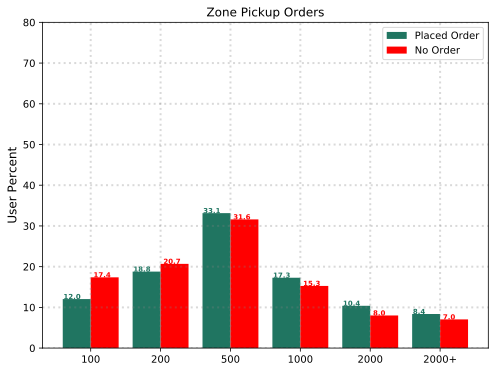

In [15]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'zone_pickup_orders_tier'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Zone Pickup Orders')
ax1.set_xticks(x)
ax1.set_xticklabels(('100', '200', '500','1000', '2000', '2000+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

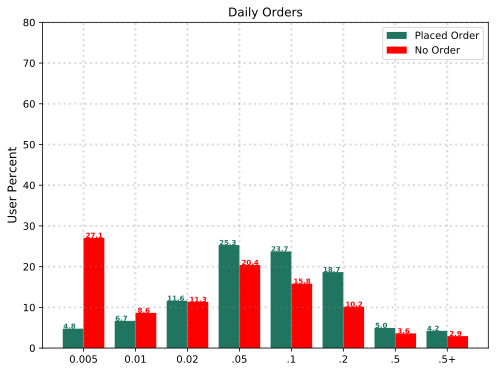

In [16]:
x = [i for i in range(8)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'daily_orders_tier'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Daily Orders')
ax1.set_xticks(x)
ax1.set_xticklabels(('0.005', '0.01','0.02', '.05', '.1', '.2', '.5', '.5+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

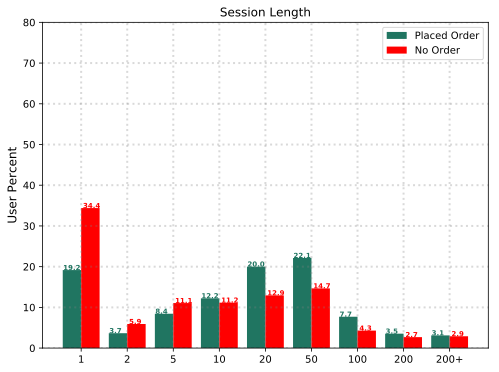

In [17]:
x = [i for i in range(9)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'session_length_tier'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Session Length')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '50', '100', '200', '200+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

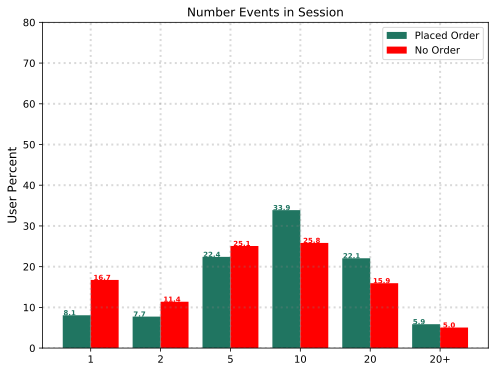

In [18]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_event_in_session_tier'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number Events in Session')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '20+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

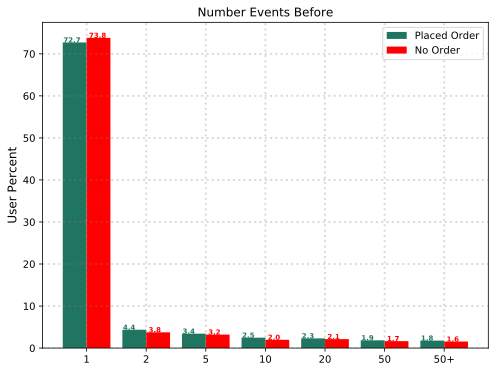

In [19]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_event_before'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number Events Before')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '50', '50+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

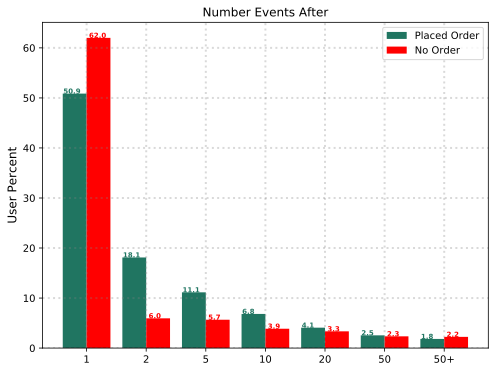

In [20]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_event_after'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number Events After')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '50', '50+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

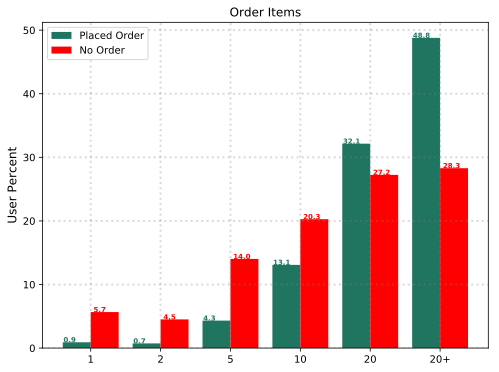

In [21]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'order_items_cnt_tier'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Order Items')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '20+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

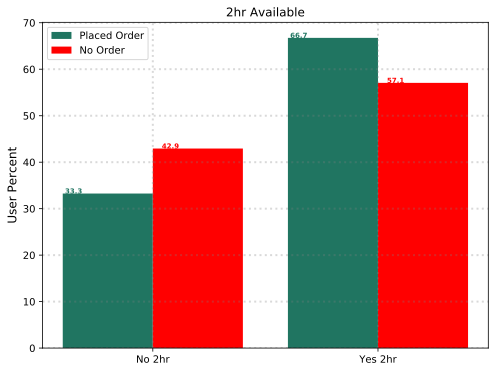

In [22]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'avail_2hr'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('2hr Available')
ax1.set_xticks(x)
ax1.set_xticklabels(('No 2hr', 'Yes 2hr'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper left')
plt.show()

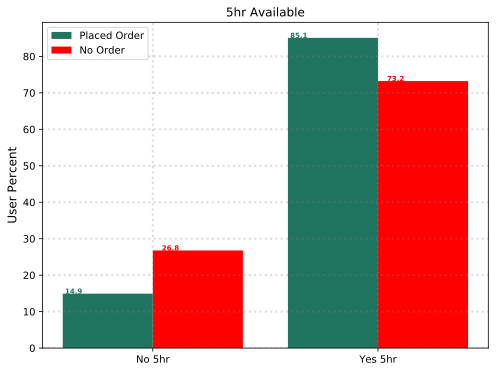

In [23]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'avail_5hr'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('5hr Available')
ax1.set_xticks(x)
ax1.set_xticklabels(('No 5hr', 'Yes 5hr'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper left')
plt.show()

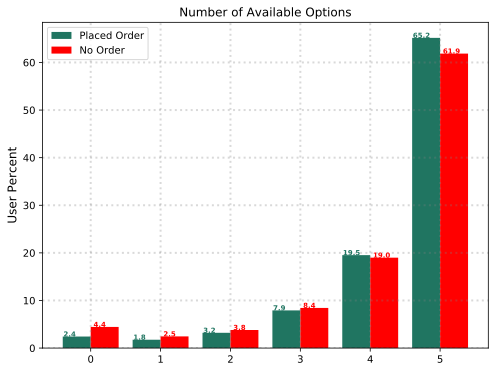

In [24]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_avail_options'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number of Available Options')
ax1.set_xticks(x)
ax1.set_xticklabels(('0', '1', '2', '3', '4', '5'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper left')
plt.show()

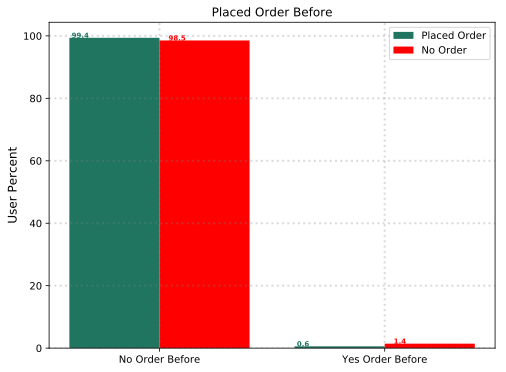

In [25]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'placed_order_before'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Placed Order Before')
ax1.set_xticks(x)
ax1.set_xticklabels(('No Order Before', 'Yes Order Before'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper right')
plt.show()

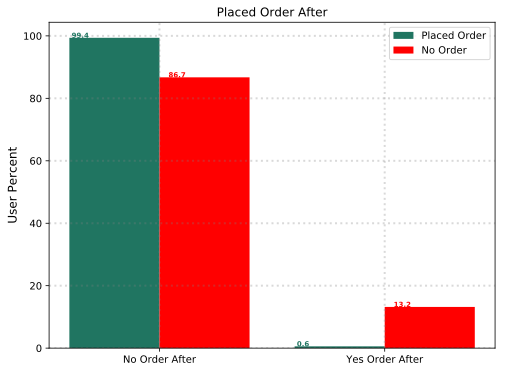

In [26]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'placed_order_after'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Placed Order After')
ax1.set_xticks(x)
ax1.set_xticklabels(('No Order After', 'Yes Order After'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper right')
plt.show()

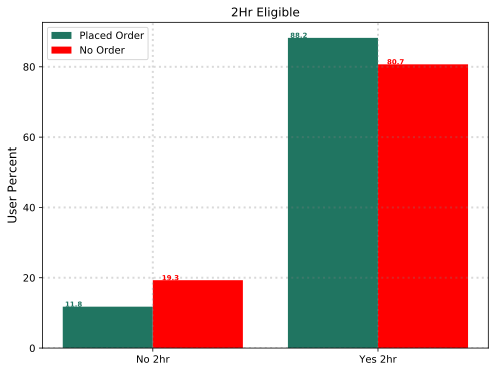

In [27]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = '2hr_eligible'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('2Hr Eligible')
ax1.set_xticks(x)
ax1.set_xticklabels(('No 2hr', 'Yes 2hr'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper left')
plt.show()

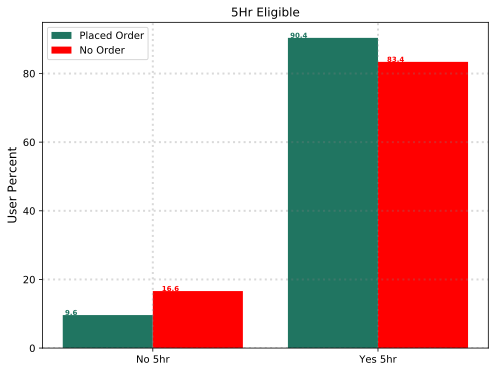

In [28]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = '5hr_eligible'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('5Hr Eligible')
ax1.set_xticks(x)
ax1.set_xticklabels(('No 5hr', 'Yes 5hr'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper left')
plt.show()

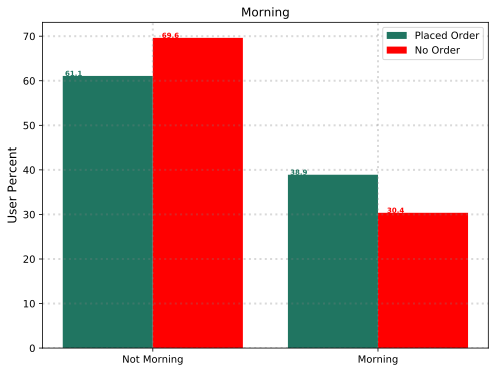

In [29]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'morning'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Morning')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Morning', 'Morning'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper right')
plt.show()

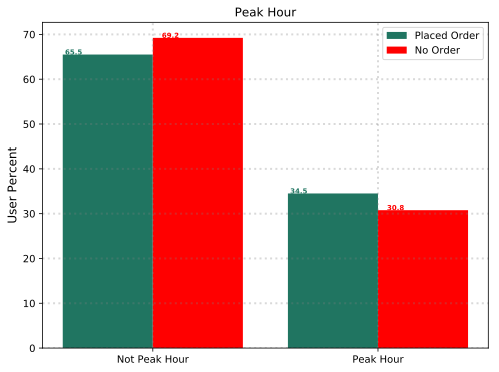

In [30]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'peak_hour'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Peak Hour')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Peak Hour', 'Peak Hour'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper right')
plt.show()

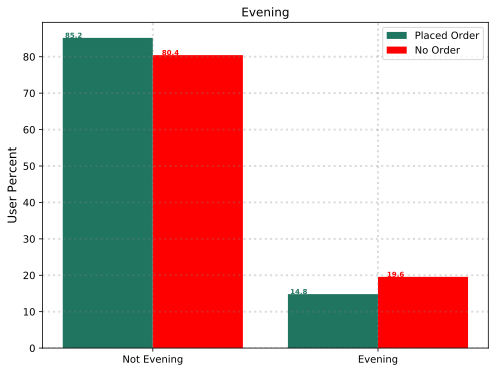

In [31]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'evening'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Evening')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Evening', 'Evening'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper right')
plt.show()

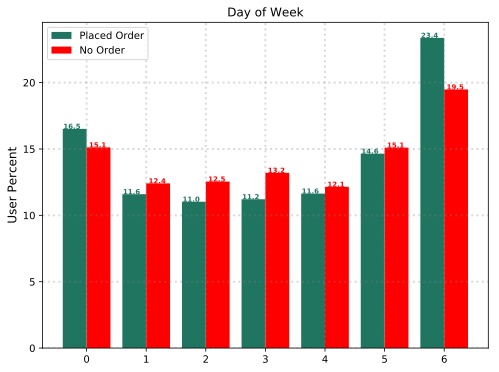

In [32]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'dow'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Day of Week')
ax1.set_xticks(x)
ax1.set_xticklabels(('0', '1', '2','3', '4', '5', '6'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper left')
plt.show()

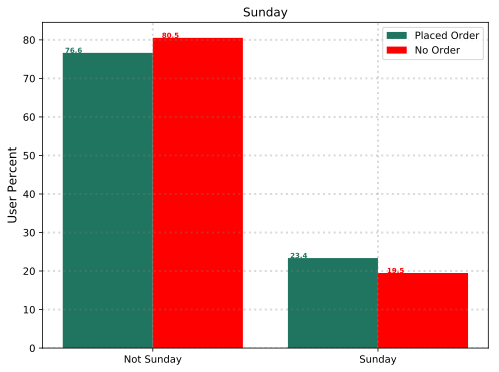

In [33]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'is_sunday'
ind_width = 0.4

df_reach_checkout = df[df['placed_order'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['placed_order'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Placed Order')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Order')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Sunday')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Sunday', 'Sunday'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='upper right')
plt.show()

In [34]:
df.columns

Index(['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
       'first_option_time_local', 'first_option_ind',
       'first_wait_time_at_event', 'second_option_time_local',
       'second_option_ind', 'second_wait_time_at_event',
       'third_option_time_local', 'third_option_ind',
       'third_wait_time_at_event', 'fourth_option_time_local',
       'fourth_option_ind', 'fourth_wait_time_at_event',
       'fifth_option_time_local', 'fifth_option_ind',
       'fifth_wait_time_at_event', 'reached_checkout', 'placed_order',
       'wait_time_at_session', 'session_start_time', 'session_end_time',
       'num_event_in_session', 'express_ind', 'order_items_cnt',
       'placed_order_before', 'num_event_before', 'placed_order_after',
       'num_event_after', 'did_order_before', 'did_order_after',
       'whl_pickup_orders', 'zone_pickup_orders',
       'zone_pickup_orders_to_fillna', 'whl_pickup_orders_to_fillna',
       'sign_in_count', 'orders_count', 'days', 'is_exp

In [35]:
df[['first_wait_time_at_event', 'first_option_ind', 'second_wait_time_at_event', 'second_option_ind', 
    'third_wait_time_at_event', 'third_option_ind',
   'fourth_wait_time_at_event', 'fourth_option_ind', 
    'fifth_wait_time_at_event', 'fifth_option_ind']].head(10)

,first_wait_time_at_event,first_option_ind,second_wait_time_at_event,second_option_ind,third_wait_time_at_event,third_option_ind,fourth_wait_time_at_event,fourth_option_ind,fifth_wait_time_at_event,fifth_option_ind
0,80.0,1.0,140.0,1.0,200.0,1.0,260.0,1.0,320.0,1.0
1,68.0,1.0,128.0,1.0,188.0,1.0,1388.0,1.0,1448.0,1.0
2,74.0,1.0,134.0,1.0,194.0,1.0,NaN,0.0,NaN,0.0
3,NaN,0.0,679.0,1.0,739.0,1.0,799.0,1.0,859.0,1.0
4,87.0,1.0,147.0,1.0,207.0,1.0,267.0,1.0,327.0,1.0
5,86.0,1.0,866.0,1.0,926.0,1.0,986.0,1.0,1046.0,1.0
6,76.0,1.0,136.0,1.0,196.0,1.0,256.0,1.0,316.0,1.0
7,78.0,1.0,858.0,1.0,918.0,1.0,978.0,1.0,1038.0,1.0
8,120.0,1.0,180.0,1.0,240.0,1.0,300.0,1.0,360.0,1.0
9,NaN,0.0,125.0,1.0,185.0,1.0,245.0,1.0,305.0,1.0


In [36]:
df[['first_option_ind', 'second_option_ind', 'third_option_ind',
   'fourth_option_ind', 'fifth_option_ind']].sum(axis=1).head(10)

0    5.0
1    5.0
2    3.0
3    4.0
4    5.0
5    5.0
6    5.0
7    5.0
8    5.0
9    4.0
dtype: float64

In [37]:
df[['first_wait_time_at_event', 'second_wait_time_at_event', 'third_wait_time_at_event',
   'fourth_wait_time_at_event', 'fifth_wait_time_at_event']].min(axis=1).head(10)

0     80.0
1     68.0
2     74.0
3    679.0
4     87.0
5     86.0
6     76.0
7     78.0
8    120.0
9    125.0
dtype: float64

In [38]:
df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token', 
       'session_start_time', 'session_end_time', 'placed_order', 
    'first_wait_time_at_event', 'first_option_ind', 'second_wait_time_at_event', 'second_option_ind', 
    'third_wait_time_at_event', 'third_option_ind',
   'fourth_wait_time_at_event', 'fourth_option_ind', 
    'fifth_wait_time_at_event', 'fifth_option_ind',
   'num_event_in_session', 'session_length']].head(10)

,date,zone_id,warehouse_location_id,user_id,visit_token,session_start_time,session_end_time,placed_order,first_wait_time_at_event,first_option_ind,second_wait_time_at_event,second_option_ind,third_wait_time_at_event,third_option_ind,fourth_wait_time_at_event,fourth_option_ind,fifth_wait_time_at_event,fifth_option_ind,num_event_in_session,session_length
0,2020-02-17,334,23537.0,60273597.0,bf2e1eba-cab3-474f-a861-03edea0ac741,2020-02-17 12:10:02,2020-02-17 12:40:45,1,80.0,1.0,140.0,1.0,200.0,1.0,260.0,1.0,320.0,1.0,10,30.716667
1,2020-02-17,305,11086.0,26491548.0,692b6c0b-8407-4749-af70-dfeb3e59dc0f,2020-02-17 15:26:24,2020-02-17 15:52:20,1,68.0,1.0,128.0,1.0,188.0,1.0,1388.0,1.0,1448.0,1.0,9,25.933333
2,2020-02-17,347,7320.0,63001437.0,4bc45aea-155d-4299-900e-33a9df7a6f89,2020-02-17 16:28:51,2020-02-17 17:18:52,1,74.0,1.0,134.0,1.0,194.0,1.0,NaN,0.0,NaN,0.0,44,50.016667
3,2020-02-17,365,17658.0,23162301.0,002602F2-0AF6-4A47-956E-B1FF49A63E44,2020-02-17 21:22:04,2020-02-17 21:41:28,1,NaN,0.0,679.0,1.0,739.0,1.0,799.0,1.0,859.0,1.0,11,19.400000
4,2020-02-17,367,17666.0,42017258.0,de01a9d8-ece5-43ab-bec6-9e1881a36527,2020-02-17 14:33:55,2020-02-17 14:33:55,1,87.0,1.0,147.0,1.0,207.0,1.0,267.0,1.0,327.0,1.0,1,0.000000
5,2020-02-17,803,19485.0,64510169.0,90b2c83d-ceea-4731-80d0-e2025a0ad44e,2020-02-17 18:33:56,2020-02-17 19:04:17,0,86.0,1.0,866.0,1.0,926.0,1.0,986.0,1.0,1046.0,1.0,3,30.350000
6,2020-02-17,825,19817.0,50070763.0,f41dec3c-7923-4a8f-bff9-bc9116bb741f,2020-02-17 09:44:10,2020-02-17 09:44:10,1,76.0,1.0,136.0,1.0,196.0,1.0,256.0,1.0,316.0,1.0,1,0.000000
7,2020-02-17,808,19484.0,49453189.0,7DF2C0D5-20AD-4D18-82CA-6D0CA7EEDEF7,2020-02-17 18:34:37,2020-02-17 18:42:15,0,78.0,1.0,858.0,1.0,918.0,1.0,978.0,1.0,1038.0,1.0,6,7.633333
8,2020-02-17,829,34310.0,73871799.0,CC22EAC8-15AE-4D5C-B4FE-45F198BEB4A0,2020-02-17 12:59:23,2020-02-17 13:24:30,1,120.0,1.0,180.0,1.0,240.0,1.0,300.0,1.0,360.0,1.0,8,25.116667
9,2020-02-17,829,34310.0,48035225.0,afb249ff-2d4b-4500-8466-d699cb060d6c,2020-02-17 13:54:12,2020-02-17 13:55:06,1,NaN,0.0,125.0,1.0,185.0,1.0,245.0,1.0,305.0,1.0,4,0.900000


### Training

In [39]:
# Production Code
# Training and testing
# No '2hr_eligbile'
    
columns = ['session_length_tier', 'num_event_in_session_tier', 
            'avail_2hr', 'avail_5hr', 'num_avail_options',
           'did_order_before', 'did_order_after', 'num_event_before_tier',
           'num_event_after_tier', 'order_items_cnt_tier',
            '2hr_eligible', '5hr_eligible',
           'morning', 'peak_hour', 'evening', 'is_sunday', 
           'zone_pickup_orders_tier',
           'daily_orders_tier', 'is_weekday', 'weekday_peak']
features = ['session_length_tier', 'num_event_in_session_tier', 
            'avail_2hr', 'avail_5hr', 'num_avail_options',
           'did_order_before', 'did_order_after', 'num_event_before_tier',
           'num_event_after_tier', 'order_items_cnt_tier',
           '5hr_eligible',
           'morning', 'peak_hour', 'evening', 'is_sunday', 
           'zone_pickup_orders_tier',
           'daily_orders_tier', 'is_weekday', 'weekday_peak'] 

data = df[columns + ['placed_order']].copy()

In [40]:
data.isnull().sum()

session_length_tier          0
num_event_in_session_tier    0
avail_2hr                    0
avail_5hr                    0
num_avail_options            0
did_order_before             0
did_order_after              0
num_event_before_tier        0
num_event_after_tier         0
order_items_cnt_tier         0
2hr_eligible                 0
5hr_eligible                 0
morning                      0
peak_hour                    0
evening                      0
is_sunday                    0
zone_pickup_orders_tier      0
daily_orders_tier            0
is_weekday                   0
weekday_peak                 0
placed_order                 0
dtype: int64

In [41]:
# Production Code
# Define model parameters and hyperparamter tuning

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data_norm = pd.DataFrame(np_scaled, columns=columns + ['placed_order'])

train, validation = train_test_split(data_norm, test_size=0.2)
validation.reset_index(inplace=True)

model = LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-10, 10))), 
    penalty='l2', # 'l1', 'l2' 
    scoring='roc_auc',  # 'accuracy', 'roc_auc', 'neg_log_loss'
    cv=5, 
    random_state=777, 
    max_iter=10000, 
    fit_intercept=True, 
    solver='newton-cg',  # 'newton-cg', ‘lbfgs’, ‘sag’; ‘liblinear’
    tol=10
)
model_fit = model.fit(train[features], train['placed_order'])

# The first column is the probability that the entry has the -1 label 
# and the second column is the probability that the entry has the +1 label.
prediction = pd.DataFrame(model_fit.predict_proba(validation[features]), columns=['NotOrdered', 'Ordered'])
prediction['pred'] = prediction['Ordered'].map(lambda x: 1 if x > 0.5 else 0)

In [42]:
# Production

from sklearn.metrics import f1_score, roc_auc_score, log_loss

prediction = prediction.join(validation[['placed_order', 'avail_2hr', 'avail_5hr', 'num_avail_options',
                            '2hr_eligible', '5hr_eligible', 'session_length_tier',
                           'order_items_cnt_tier', 'did_order_after',
                           'num_event_in_session_tier', 'num_event_before_tier',
                           'num_event_after_tier', 'did_order_before', 'daily_orders_tier']])

f1 = f1_score(validation['placed_order'], prediction['pred'])
print('f1: %.3f.'%(f1))
f1_micro = f1_score(validation['placed_order'], prediction['pred'], average='micro')
print('f1 micro: %.3f.'%(f1_micro))
f1_macro = f1_score(validation['placed_order'], prediction['pred'], average='macro')
print('f1 macro: %.3f.'%(f1_macro))
roc_auc = roc_auc_score(validation['placed_order'], prediction.Ordered)
print('ROC AUC: %.3f.'%(roc_auc))
log_loss = log_loss(validation['placed_order'], prediction.Ordered)
print('Log Loss: %.3f.'%(log_loss))

prediction.head(3)

f1: 0.871.
f1 micro: 0.799.
f1 macro: 0.711.
ROC AUC: 0.791.
Log Loss: 0.469.


,NotOrdered,Ordered,pred,placed_order,avail_2hr,avail_5hr,num_avail_options,2hr_eligible,5hr_eligible,session_length_tier,order_items_cnt_tier,did_order_after,num_event_in_session_tier,num_event_before_tier,num_event_after_tier,did_order_before,daily_orders_tier
0,0.642334,0.357666,0,1.0,1.0,1.0,1.0,0.0,0.0,0.250,0.4,0.0,0.4,0.000000,0.000000,0.0,0.000000
1,0.428181,0.571819,1,0.0,0.0,1.0,0.8,1.0,1.0,0.500,0.8,0.0,0.6,0.833333,0.333333,0.0,0.142857
2,0.099268,0.900732,1,1.0,1.0,1.0,1.0,1.0,1.0,0.625,1.0,0.0,0.6,0.000000,0.166667,0.0,0.428571


In [43]:
# Production 
# For lost demand

ideal_data = validation.copy()
ideal_data.loc[(ideal_data['avail_2hr'] == 0) & (ideal_data['2hr_eligible'] == 1), 'avail_2hr'] = 1
ideal_data.loc[(ideal_data['avail_5hr'] == 0) & (ideal_data['5hr_eligible'] == 1), 'avail_5hr'] = 1
ideal_data.loc[ideal_data['num_avail_options'] != 5, 'num_avail_options'] = 5
ypred_ideal = model_fit.predict_proba(ideal_data[features])
prediction = prediction.assign(pred_proba_ideal=list(ypred_ideal))
prediction['pred_proba_ideal'] = prediction['pred_proba_ideal'].map(lambda x: x[1])
prediction['ld'] = prediction['pred_proba_ideal'] - prediction['Ordered']
prediction = prediction[['Ordered', 'pred', 'pred_proba_ideal', 'ld', 
                         'placed_order', 'avail_2hr', 'avail_5hr', 'num_avail_options',
                         '5hr_eligible', 'session_length_tier',
                           'order_items_cnt_tier', 'did_order_after',
                           'num_event_in_session_tier', 'num_event_before_tier',
                           'num_event_after_tier', 'did_order_before', 'daily_orders_tier']]
print('Positive LD: %d'%(len(prediction[prediction['ld'] > 0])))
print('Zero LD: %d'%(len(prediction[prediction['ld'] == 0])))
print('Negative LD: %d'%(len(prediction[prediction['ld'] < 0])))

Positive LD: 15966
Zero LD: 0
Negative LD: 0


In [44]:
prediction[(prediction['ld'] > 0) & (prediction['avail_2hr'] == 0)].head(10)

,Ordered,pred,pred_proba_ideal,ld,placed_order,avail_2hr,avail_5hr,num_avail_options,5hr_eligible,session_length_tier,order_items_cnt_tier,did_order_after,num_event_in_session_tier,num_event_before_tier,num_event_after_tier,did_order_before,daily_orders_tier
1,0.571819,1,0.759564,0.187745,0.0,0.0,1.0,0.8,1.0,0.500,0.8,0.0,0.6,0.833333,0.333333,0.0,0.142857
5,0.604045,1,0.788655,0.184610,1.0,0.0,1.0,0.6,1.0,0.000,0.6,0.0,0.2,0.000000,0.000000,0.0,0.428571
8,0.942598,1,0.976490,0.033892,1.0,0.0,1.0,0.4,1.0,0.500,1.0,0.0,0.8,0.000000,0.000000,0.0,0.714286
9,0.710821,1,0.836969,0.126148,0.0,0.0,0.0,0.6,0.0,0.625,1.0,0.0,0.6,0.000000,0.000000,0.0,0.142857
14,0.966423,1,0.985525,0.019103,1.0,0.0,1.0,0.8,1.0,0.625,1.0,0.0,0.6,0.333333,0.000000,0.0,1.000000
18,0.455303,0,0.818109,0.362806,1.0,0.0,0.0,0.0,1.0,0.000,1.0,0.0,0.2,0.500000,0.000000,0.0,0.142857
23,0.532015,1,0.703644,0.171629,1.0,0.0,0.0,0.6,0.0,0.500,0.6,0.0,0.6,0.000000,0.000000,0.0,0.428571
25,0.725287,1,0.934238,0.208951,0.0,0.0,0.0,0.0,1.0,0.000,1.0,0.0,0.0,0.000000,0.000000,0.0,0.714286
32,0.736106,1,0.872174,0.136067,1.0,0.0,1.0,0.6,1.0,0.625,1.0,0.0,0.8,0.000000,0.000000,0.0,0.000000
34,0.925630,1,0.967151,0.041521,1.0,0.0,1.0,0.8,1.0,0.500,1.0,0.0,0.6,0.333333,0.333333,0.0,0.714286


In [45]:
coefficients = [(name, round(coef, 3)) for name, coef in zip(features, model_fit.coef_[0])]

In [46]:
coefficients.sort(key=lambda x: x[1], reverse=True)
coefficients

[('order_items_cnt_tier', 2.486),
 ('daily_orders_tier', 2.449),
 ('session_length_tier', 0.782),
 ('avail_5hr', 0.688),
 ('zone_pickup_orders_tier', 0.517),
 ('num_event_in_session_tier', 0.457),
 ('num_avail_options', 0.167),
 ('avail_2hr', 0.158),
 ('morning', 0.158),
 ('weekday_peak', 0.116),
 ('is_sunday', 0.115),
 ('peak_hour', -0.044),
 ('is_weekday', -0.058),
 ('5hr_eligible', -0.1),
 ('num_event_before_tier', -0.12),
 ('evening', -0.239),
 ('did_order_before', -0.357),
 ('num_event_after_tier', -0.949),
 ('did_order_after', -3.521)]